In [69]:
import pandas as pd
import numpy as np
import os
from matplotlib import pyplot as plt

from qnorm import quantile_normalize

from tsa.preprocessing import get_sample_info, tpm_normalization, merge_replicates
from tsa.gpr import gpr
from tsa.gene_selection import score_normalization, plot_scores, best_n_genes
from tsa.clustering import cluster_genes
from tsa.alignment import time_series_alignment, best_alignment_graph, get_cost_matrix, plot_alignment
from tsa.utils import inference_timeseries, all_numeric, list2floats

plt.rcParams['figure.figsize'] = [8, 6]

In [2]:
# get all orthologue genes
df = pd.read_csv("orthologs/DR_XT_orthologs.tsv", sep="\t", dtype=str)
df = df.rename(columns={
    "Tropical clawed frog gene name": "xt_name",
    "Tropical clawed frog gene stable ID": "xt_id",
    "Gene name": "dr_name",
    "Gene stable ID": "dr_id",
}, errors="raise")

# filter genes
df = df[df['Tropical clawed frog homology type'] == 'ortholog_one2one']
df = df[["dr_name", "dr_id", "xt_name", "xt_id"]]
df = df.dropna(subset=["xt_id", "dr_id"])
df = df.drop_duplicates()
    
tpm_file = "data/GRCz11-TPM.tsv"
tpms = pd.read_csv(tpm_file, sep="\t", index_col=0)
df = df[df["dr_id"].isin(tpms.index)]

tpm_file = "data/XT9.1-TPM.tsv"
tpms = pd.read_csv(tpm_file, sep="\t", index_col=0)
df = df[df["xt_id"].isin(tpms.index)]

orthologs = df.sort_values("dr_id", ignore_index=True)
del df
del tpms

orthologs

,dr_name,dr_id,xt_name,xt_id
0,slc35a5,ENSDARG00000000001,slc35a5,ENSXETG00000002426
1,nrf1,ENSDARG00000000018,nrf1,ENSXETG00000016306
2,itsn1,ENSDARG00000000086,itsn1,ENSXETG00000014182
3,myh10,ENSDARG00000000103,myh10,ENSXETG00000016345
4,usp49,ENSDARG00000000229,usp49,ENSXETG00000011843
...,...,...,...,...
5730,CABZ01086812.1,ENSDARG00000117001,slc2a15a,ENSXETG00000015992
5731,CABZ01060373.1,ENSDARG00000117069,inf2,ENSXETG00000008613
5732,CKS2,ENSDARG00000117089,cks2,ENSXETG00000010855
5733,BX323087.1,ENSDARG00000117155,ppp1r12b,ENSXETG00000017095


### files

In [3]:
template_tpm_file = "data/GRCz11-TPM.tsv"
template_tpms = pd.read_csv(template_tpm_file, sep="\t", index_col=0)

template_samples_file = "data/white_mpf_samples.tsv"
template_gpr_inference_file = "data/white_mpf_gpr.tsv"
template_gpr_scores_file = "data/white_mpf_score.tsv"

query_tpm_file = "data/XT9.1-TPM.tsv"
query_tpms = pd.read_csv(tpm_file, sep="\t", index_col=0)

query_samples_file = "data/owensA1_mpf_samples.tsv"
query_gpr_inference_file = "data/owensA1_mpf_gpr.tsv"
query_gpr_scores_file = "data/owensA1_mpf_score.tsv"

new_gpr = False

### Template preprocessing

In [4]:
# preprocessing
template_samples = pd.read_csv(template_samples_file, sep="\t", index_col=0)
template_sample_order, template_time2samples = get_sample_info(template_samples)

template_tpms = tpm_normalization(template_tpms, template_sample_order, min_value=5, min_median_value=0, verbose=True)

template_tpms.head(3)

11063 genes with max below 5 TPM (34%)
2243 genes with median below or equal to 0 TPM (10%)
18906 genes, 90 samples left after filtering


,1-cell-1,1-cell-2,1-cell-3,1-cell-4,1-cell-5,2-cell-1,2-cell-2,2-cell-3,2-cell-4,2-cell-5,...,Day-4-1,Day-4-2,Day-4-3,Day-4-4,Day-4-5,Day-5-1,Day-5-2,Day-5-3,Day-5-4,Day-5-5
gene,,,,,,,,,,,,,,,,,,,,,
ENSDARG00000000001,3.500623,3.193223,2.993834,3.134451,2.930888,3.063963,3.358324,3.177872,3.182704,3.292535,...,1.268145,0.875185,1.372952,0.953276,1.219284,1.252780,1.293310,1.701401,1.087258,0.985310
ENSDARG00000000002,1.798363,1.850706,1.549031,1.842664,1.618451,2.919417,2.731890,2.547173,2.881035,2.495728,...,2.909071,3.259391,3.423040,3.203155,2.933308,3.054464,3.049627,3.124625,2.925538,3.317229
ENSDARG00000000018,3.825139,3.883515,3.443959,3.688393,3.947403,4.004615,4.161532,4.129312,4.164329,3.913867,...,4.537668,4.042059,4.059302,4.259864,4.103876,4.459250,4.421675,4.362885,4.252356,4.371778


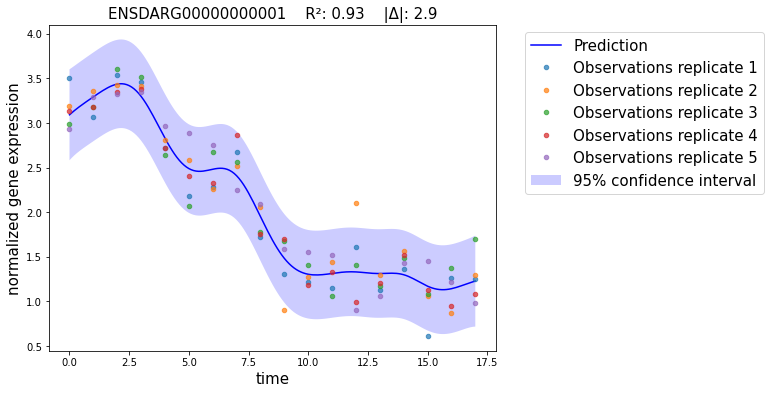

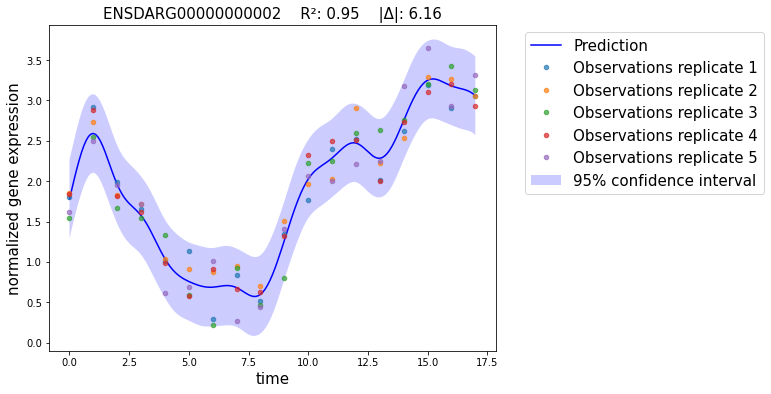

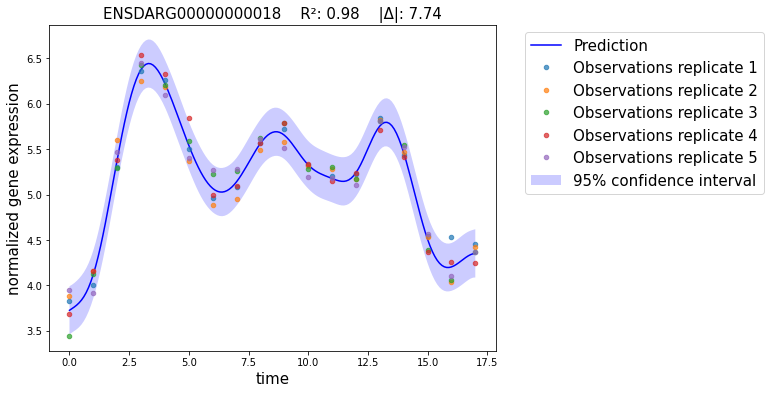

In [5]:
# # linear space
# extended_timepoints = list(np.round(np.linspace(min(time2samples), max(time2samples), 10), 2))

# infer n timepoints for each original timepoint 
timepoints_per_sample = 10
extended_timepoints = inference_timeseries(list(template_time2samples), timepoints_per_sample)

# run 3x with pictures
tmp, _ = gpr(template_time2samples, template_tpms, extended_timepoints, plot=True, verbose=False, run_n=3)

if new_gpr:
    # run with all genes
    template_tpms_inf, gpr_scores = gpr(template_time2samples, template_tpms, extended_timepoints, plot=False, verbose=True, run_n=None)
    
    template_tpms_inf.to_csv(template_gpr_inference_file, sep="\t")
    template_gpr_scores.to_csv(template_gpr_scores_file, sep="\t")
else:
    template_tpms_inf = pd.read_csv(template_gpr_inference_file, sep="\t", index_col=0)
    template_gpr_scores = pd.read_csv(template_gpr_scores_file, sep="\t", index_col=0)


In [6]:
# when loading a gpr inference table, make sure the rows and columns match the settings
if new_gpr is False:
    gene = tmp.index[0]
    if tmp.index[0] != template_tpms_inf.index[0]:
        raise ValueError("`template_tpms` gene order has changed since creating the template_tpms_inf table")
    if tmp.columns.equals(template_tpms_inf.columns):
        raise ValueError("`extended_timepoints` has changed since creating the template_tpms_inf table")
    print("all good!")

all good!


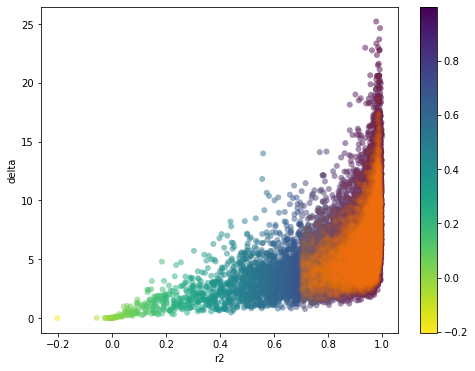

In [7]:
# remove genes that weren't modelled accurately
weight_expr=0
min_r2 = 0.7
weight_r2=1

template_gpr_scores.dropna(inplace=True)
gpr_normscores = score_normalization(template_gpr_scores, weight_expr, weight_r2)
top_template_genes = gpr_normscores[gpr_normscores.r2 >= min_r2].index.to_list()
plot_scores(gpr_normscores, highlight_top_n=len(top_template_genes))

# n = 12_000
# top_template_genes = best_n_genes(gpr_normscores, n)
# gpr_normscores = score_normalization(gpr_scores, weight_expr=1, weight_r2=3)
# plot_scores(gpr_normscores, highlight_top_n=n)

### Query preprocessing

In [9]:
# # preprocessing
# query_samples = pd.read_csv(query_samples_file, sep="\t", index_col=0)
# sample_order, time2samples = get_sample_info(query_samples)

# target_distribution = template_tpms[template_tpms.columns[0]].to_list()
# query_tpms = tpm_normalization(tpms, sample_order, min_value=5, min_median_value=0, qnorm_target_dist=target_distribution)

# # TODO: other methods, such as GPR?
# query_tpms = merge_replicates(query_tpms, time2samples, how="mean")

# if all_numeric(time2samples):
#     # convert time to numeric
#     samples2time = query_samples.to_dict()["time"]
#     query_tpms = query_tpms.rename(columns=samples2time)

# query_tpms.head(3)

In [10]:
# preprocessing
query_samples = pd.read_csv(query_samples_file, sep="\t", index_col=0)
query_sample_order, query_time2samples = get_sample_info(query_samples)

query_tpms = tpm_normalization(query_tpms, query_sample_order, min_value=5, min_median_value=0, verbose=True)

query_tpms.head(3)

6607 genes with max below 5 TPM (31%)
313 genes with median below or equal to 0 TPM (2%)
14159 genes, 53 samples left after filtering


,GSM1606183,GSM1606184,GSM1606185,GSM1606186,GSM1606187,GSM1606188,GSM1606189,GSM1606190,GSM1606191,GSM1606192,...,GSM1606226,GSM1606227,GSM1606228,GSM1606229,GSM1606230,GSM1606231,GSM1606232,GSM1606233,GSM1606234,GSM1606235
gene,,,,,,,,,,,,,,,,,,,,,
ENSXETG00000000002,6.131145,5.921640,5.998804,6.173674,6.119142,6.259830,6.370552,6.320937,6.400027,6.237597,...,5.490205,5.543036,5.546245,5.679767,5.636308,5.700778,5.943369,5.930271,5.645986,5.643494
ENSXETG00000000003,6.111369,6.290138,6.274922,6.228988,6.207515,6.132275,6.137256,5.965053,5.854107,5.922741,...,5.061129,4.948665,5.032481,4.139545,4.887050,4.604822,3.982709,4.210871,4.935422,4.906007
ENSXETG00000000004,4.212082,4.236750,4.049790,3.841060,3.684565,3.447427,3.320187,3.418296,3.336306,3.648000,...,3.623838,3.655968,3.703871,3.500498,3.397711,3.481193,3.148725,3.249156,3.184631,3.197012


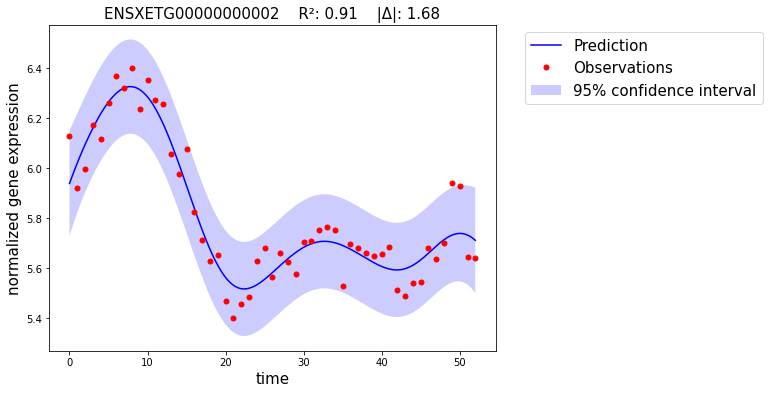

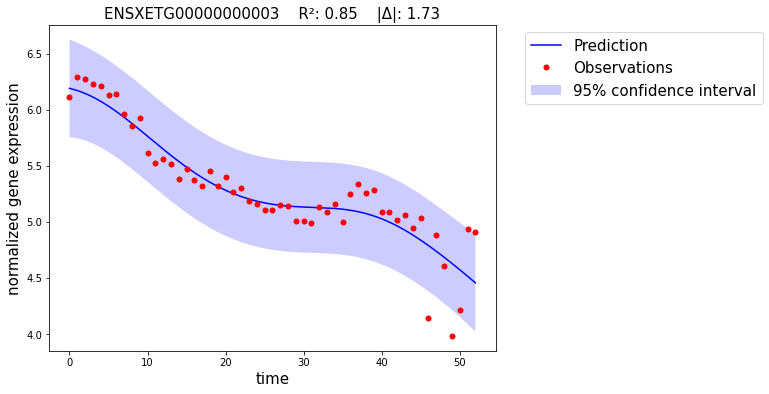

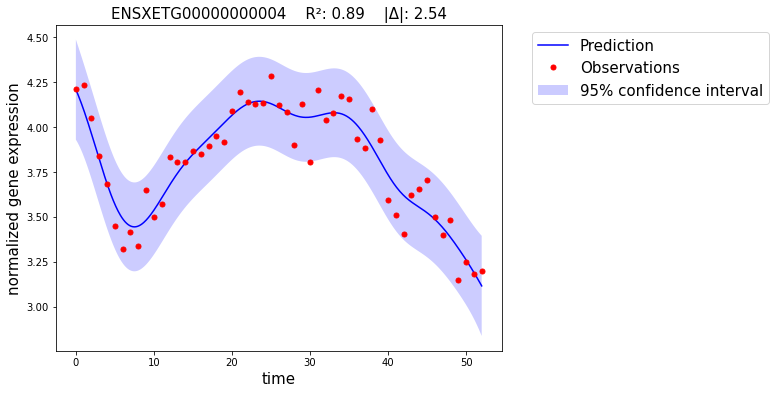

In [11]:
# # linear space
# extended_timepoints = list(np.round(np.linspace(min(time2samples), max(time2samples), 10), 2))

# infer n timepoints for each original timepoint 
timepoints_per_sample = 10
query_extended_timepoints = inference_timeseries(list(query_time2samples), timepoints_per_sample)

# run 3x with pictures
tmp, _ = gpr(query_time2samples, query_tpms, query_extended_timepoints, plot=True, verbose=False, run_n=3)

if new_gpr:
    # run with all genes
    query_tpms_inf, gpr_scores = gpr(template_time2samples, template_tpms, extended_timepoints, plot=False, verbose=True, run_n=None)
    
    query_tpms_inf.to_csv(query_gpr_inference_file, sep="\t")
    query_gpr_scores.to_csv(query_gpr_scores_file, sep="\t")
else:
    query_tpms_inf = pd.read_csv(query_gpr_inference_file, sep="\t", index_col=0)
    query_gpr_scores = pd.read_csv(query_gpr_scores_file, sep="\t", index_col=0)


In [12]:
# when loading a gpr inference table, make sure the rows and columns match the settings
if new_gpr is False:
    gene = tmp.index[0]
    if tmp.index[0] != query_tpms_inf.index[0]:
        raise ValueError("`template_tpms` gene order has changed since creating the template_tpms_inf table")
    if tmp.columns.equals(query_tpms_inf.columns):
        raise ValueError("`extended_timepoints` has changed since creating the template_tpms_inf table")
    print("all good!")

all good!


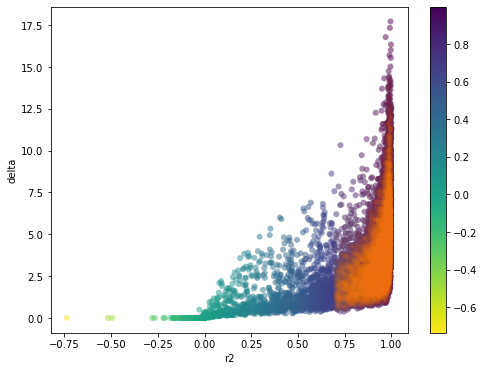

In [13]:
# remove genes that weren't modelled accurately
weight_expr=0
min_r2 = 0.7
weight_r2=1

query_gpr_scores.dropna(inplace=True)
query_gpr_normscores = score_normalization(query_gpr_scores, weight_expr, weight_r2)
top_query_genes = query_gpr_normscores[query_gpr_normscores.r2 >= min_r2].index.to_list()
plot_scores(query_gpr_normscores, highlight_top_n=len(top_query_genes))

# n = 12_000
# top_template_genes = best_n_genes(gpr_normscores, n)
# gpr_normscores = score_normalization(gpr_scores, weight_expr=1, weight_r2=3)
# plot_scores(gpr_normscores, highlight_top_n=n)

### overlapping genes

In [47]:
print(len(top_template_genes), "template genes")
print(len(top_query_genes), "query genes")

df = orthologs.copy()
df = df[df.dr_id.isin(top_template_genes)]
df = df[df.xt_id.isin(top_query_genes)]

orto_dict = df[["dr_id", "xt_id"]].set_index("xt_id").to_dict()['dr_id']
starting_genes = list(orto_dict.values())

print(len(starting_genes), "overlapping genes")

17238 template genes
12082 query genes
2732 overlapping genes


In [48]:
t = template_tpms_inf.loc[orto_dict.values()]

q = query_tpms_inf.loc[orto_dict.keys()]
q = q.rename(mapper=orto_dict)

target_distribution = t[t.columns[0]].to_list()
q = quantile_normalize(q, axis=1, target=target_distribution)

assert len(t) == len(q)
q.head(2)

,240.0,243.0,246.0,249.0,252.0,255.0,258.0,261.0,264.0,267.0,...,2106.0,2112.0,2118.0,2124.0,2130.0,2136.0,2142.0,2148.0,2154.0,2160.0
gene,,,,,,,,,,,,,,,,,,,,,
ENSDARG00000000001,1.725294,1.72600,1.726033,1.736983,1.737026,1.743459,1.746703,1.772921,1.774200,1.776885,...,0.962516,0.947474,0.944958,0.938629,0.932379,0.927888,0.927230,0.927128,0.923402,0.920520
ENSDARG00000000018,3.699144,3.68774,3.686388,3.681327,3.681397,3.682160,3.682160,3.681327,3.678527,3.675261,...,2.777641,2.767733,2.763417,2.751272,2.763417,2.769143,2.769143,2.785287,2.785287,2.785287


In [49]:
t.head(2)

,0.0,4.5,9.0,13.5,18.0,22.5,27.0,31.5,36.0,40.5,...,5904.0,6048.0,6192.0,6336.0,6480.0,6624.0,6768.0,6912.0,7056.0,7200.0
gene,,,,,,,,,,,,,,,,,,,,,
ENSDARG00000000001,3.092071,3.115739,3.138178,3.159550,3.180035,3.199817,3.219072,3.237958,3.256605,3.275101,...,1.149415,1.156988,1.165421,1.174472,1.183893,1.193437,1.202859,1.211929,1.220430,1.228167
ENSDARG00000000018,3.726486,3.744112,3.762576,3.783367,3.808093,3.838399,3.875892,3.922061,3.978198,4.045319,...,4.215319,4.230695,4.248905,4.268701,4.288824,4.308033,4.325136,4.339017,4.348671,4.353236


In [50]:
template_gene_clusters = cluster_genes(t, starting_genes)

### TSA

Cycle 1, using all 2732 genes.

Average TSA of 10 alignments with 20% of genes per cluster 
(10 clusters, 548 total genes)


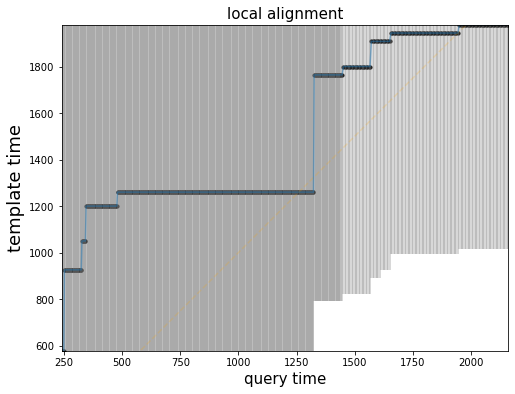

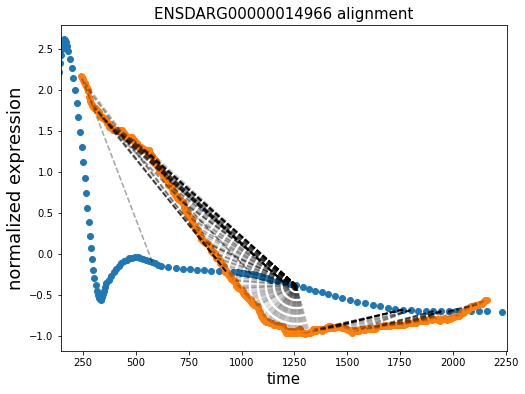

Cycle 2, using the best 2182 genes.

Average TSA of 10 alignments with 20% of genes per cluster 
(10 clusters, 437 total genes)


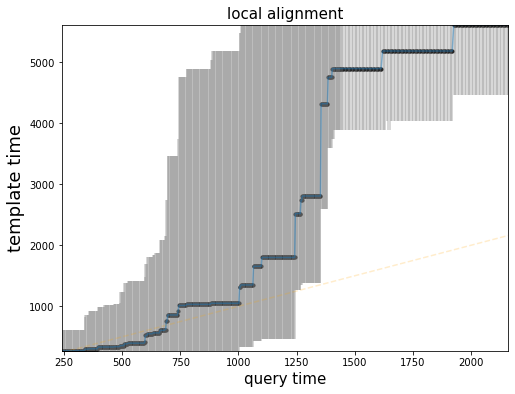

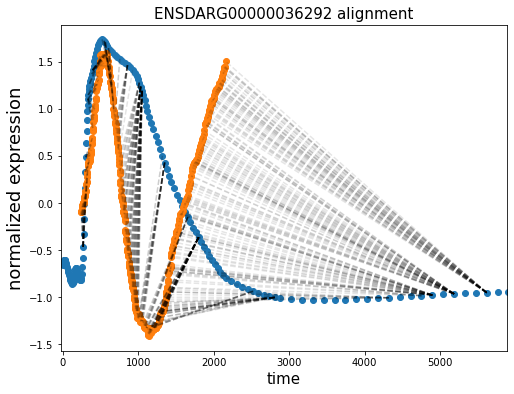

Cycle 3, using the best 1743 genes.

Average TSA of 10 alignments with 20% of genes per cluster 
(10 clusters, 348 total genes)


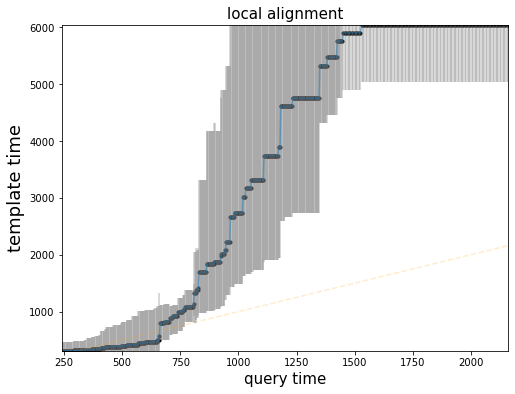

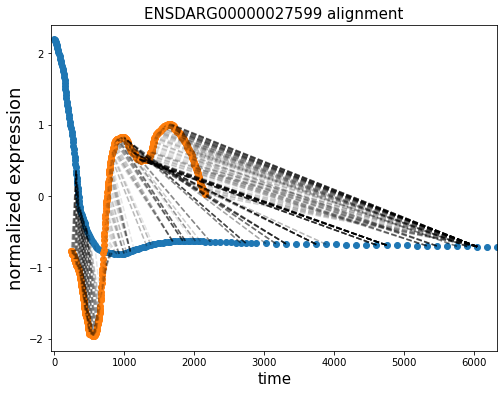

In [52]:
path = time_series_alignment(t, q, template_gene_clusters, tries=10, cycles=3)

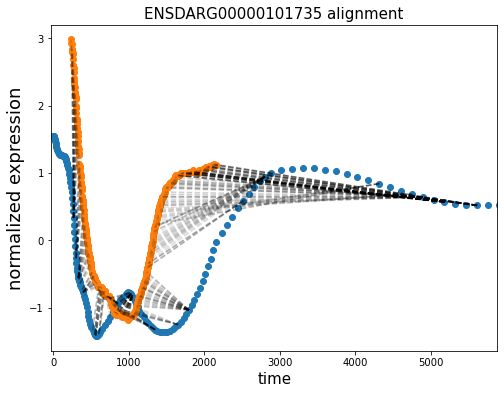

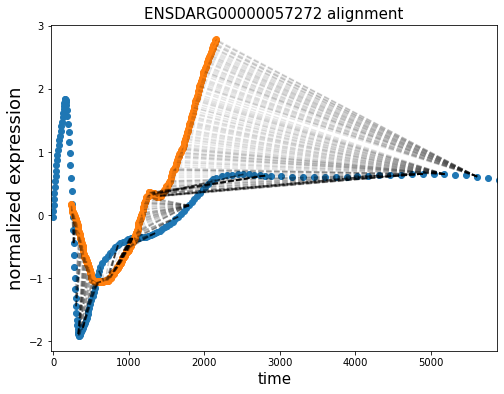

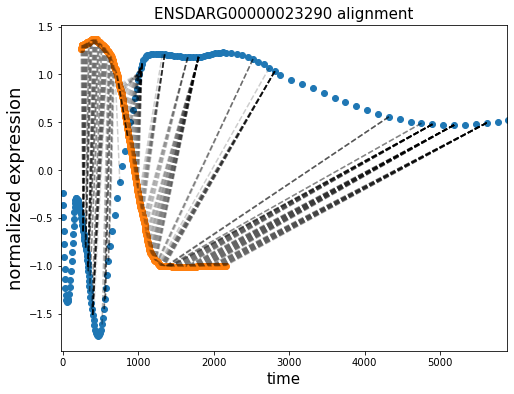

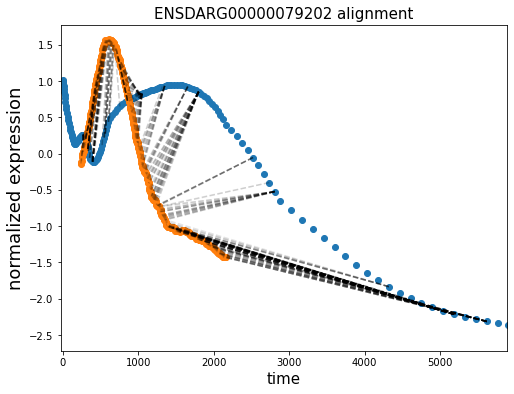

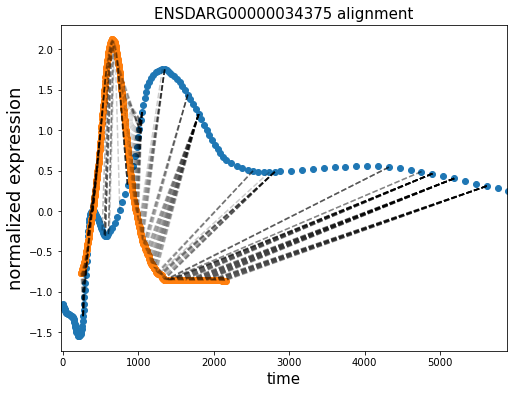

In [110]:
import random
import sklearn


def plot_gene(query_tpms, template_tpms_inf, path, gene=None, scale=False):
    """
    Visualize annotated time vs inferred time for a specified gene.
    Requires that annotated time is numeric for both template and query.
    """
    if gene is None:
        gene = random.sample(list(query_tpms.index), 1)[0]
    
    x1 = list2floats(template_tpms_inf.columns)
    x2 = list2floats(query_tpms.columns)
    
    y1 = template_tpms_inf.loc[gene].to_list()
    y2 = query_tpms.loc[gene].to_list() 
    if scale:
        y1 = sklearn.preprocessing.scale(y1)
        y2 = sklearn.preprocessing.scale(y2)
    
    plt.scatter(x=x1, y=y1)
    plt.scatter(x=x2, y=y2)
    for n in range(len(x2)):
        m = path[n]
        plt.plot((x1[m], x2[n]), (y1[m], y2[n]), color = 'black', alpha=0.1, linestyle='--')

    plt.title(f"{gene} alignment", fontsize=15)
    plt.ylabel("normalized expression", fontsize=18)
    plt.xlabel("time", fontsize=15)
    start = min(x1[path[0]], x2[0])
    end = max(x1[path[-1]], x2[-1])
    a_bit = (end - start) * 0.05
    plt.xlim(start - a_bit, end + a_bit)
    plt.show()

# recreate t and q
t = template_tpms_inf.loc[orto_dict.values()]

q = query_tpms_inf.loc[orto_dict.keys()]
q = q.rename(mapper=orto_dict)

target_distribution = t[t.columns[0]].to_list()
q = quantile_normalize(q, axis=1, target=target_distribution)

# cherry pick a path
p = path[1]

# config
plt.rcParams['figure.figsize'] = [8, 6]

# seamingly similar genes (from random tests)
genes = [
    'ENSDARG00000101735',
    'ENSDARG00000057272',
    'ENSDARG00000023290',
    'ENSDARG00000079202',
    'ENSDARG00000034375',
]
for gene in genes:
    plot_gene(q, t, p, scale=True, gene=gene)


In [67]:
alignment_dir = "alignments"
t_fname = os.path.basename(template_samples_file).replace("_samples.tsv", "")
q_fname = os.path.basename(query_samples_file).replace("_samples.tsv", "")
alignment_file = os.path.join(alignment_dir, f"cross_species_{t_fname}_to_{q_fname}_alignment.tsv")


p = path[1]
query_time = list(time2samples)
mapped = pd.DataFrame(data={
    "annotated_time": query_extended_timepoints,
    "inferred_time": [extended_timepoints[i] for i in p],
#     "samples": query_time2samples.values(),
}).set_index("annotated_time")
mapped.to_csv(alignment_file, sep="\t")
print(f"saving mapping in '{alignment_file}'.")

mapped = pd.read_csv(alignment_file, sep="\t", index_col=0)
mapped.head(3)

saving mapping in 'alignments/cross_species_white_mpf_to_owensA1_mpf_alignment.tsv'.


,inferred_time
annotated_time,
240.0,270.84
243.0,270.84
246.0,270.84


In [70]:
alignment_files =[
    'alignments/white_mpf_to_white_mpf_alignment.tsv',
    'alignments/cross_species_white_mpf_to_owensA1_mpf_alignment.tsv',
]

In [71]:
def read_alignments(alignment_file):
    fname = os.path.basename(alignment_file)
    t_fname = fname.split("_to_")[0]
    q_fname = fname.split("_to_")[1].replace("_alignment.tsv", "")
    alignment = pd.read_csv(alignment_file, sep="\t", index_col=0)
    return alignment, q_fname, t_fname

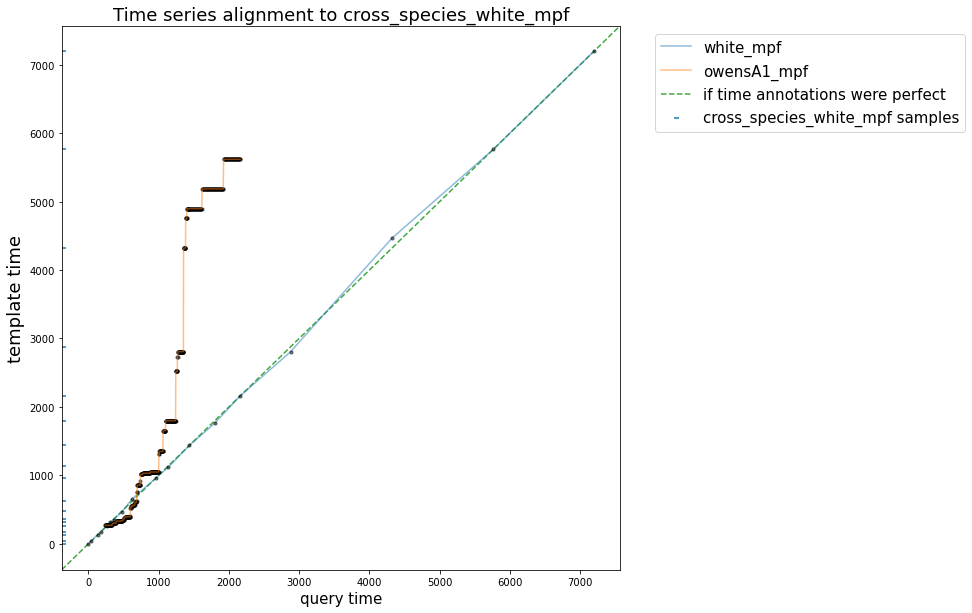

In [74]:
def plot_multi_alignment(template_timepoints, alignment_files, to_file=None):
    # limit the plot to the range of the query series (plus padding)
    start = template_timepoints[0]
    end = 0

    # plot each time series
    for alignment_file in alignment_files:
        alignment, query_label, template_label = read_alignments(alignment_file)
        x = alignment.index  # annotated_time
        y = alignment.inferred_time
        if query_label ==  template_label:
            # control data can be in the background
            plt.plot(x, y, alpha=0.5, label=query_label, zorder=-5)
            plt.scatter(x, y, alpha=0.5, s=10, color="black", zorder=-4)
        else:
            plt.plot(x, y, alpha=0.5, label=query_label)
            plt.scatter(x, y, alpha=0.5, s=10, color="black")

        end = max(end, y.iloc[-1]*1.05)
    start = start - (end - start)*0.05

    # add template samples at their annotated time on the y-axis
    ts_y = template_timepoints
    ts_x = start+end*0.003  # more the points into the plot a little (for visual clarity)
    plt.scatter([ts_x for i in ts_y], ts_y, alpha=1, s=25, label=f"{template_label} samples", marker='_')

    # add diagonal
    plt.plot([start, end], [start, end], label="if time annotations were perfect", alpha=0.9, ls='--', zorder=-10)

    plt.xlim(start, end)
    plt.ylim(start, end)

    plt.title(f"Time series alignment to {template_label}", fontsize=18)
    plt.ylabel("template time", fontsize=18)
    plt.xlabel("query time", fontsize=15)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=15)
    
    if to_file:
        plt.savefig(to_file, bbox_inches='tight')
    plt.show()

# plt.rcParams['figure.figsize'] = [8, 6]
plt.rcParams['figure.figsize'] = [10, 10]

template_time = list2floats(template_time2samples)
fname = "alignments/cross_species_DR_white_mpf_to_XT_owensA1_MultiAlignment.pdf"
plot_multi_alignment(template_time, alignment_files, to_file=fname)  # None)  # 


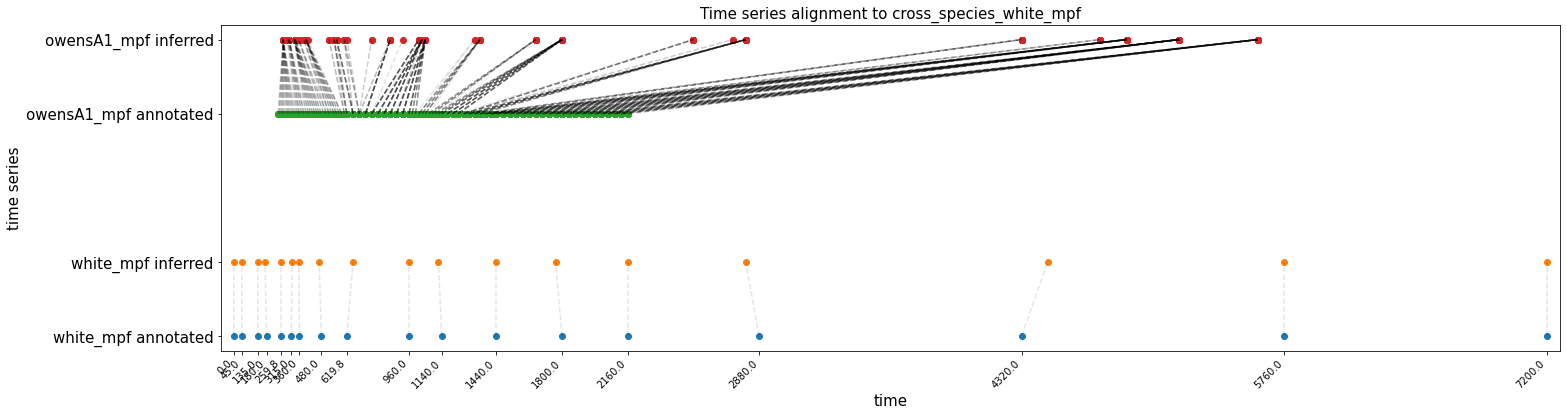

In [76]:
def nearest(myNumber, myList):
    return min(myList, key=lambda x:abs(x-myNumber))


# nearest(2.1, [1,2,3])

def plot_timeline(template: pd.DataFrame, alignment_files: dict, to_file=None):
#     dt = template.index.dtype
    t_ext_time = list(template.index)  # annotated query time is mapped to the nearest template point
    xlabels = list(template.xlabels.dropna())
    xticks = list(template.xticks.dropna())
    
    ylabels = []
    yticks = []
    n = 0
    for alignment_file in alignment_files:
        query, query_label, template_label = read_alignments(alignment_file)
#         query.index.astype(dt)
        
        # plot annotated time
        x1 = []
        for q_ann in list(query.index):
            t_time = nearest(q_ann, t_ext_time)
            x1.append(template.loc[t_time]["x"])
#         x1 = list(template.loc[query.index]["x"])        
        y = list(np.zeros_like(x1) + n)
        label = f"{query_label} annotated"
        plt.scatter(x=x1, y=y, label=label)
        ylabels.append(label)
        yticks.append(n)
        n += 1
        
        # plot inferred time
        x2 = list(template.loc[query.inferred_time]["x"])
        y = list(np.zeros_like(x2) + n)
        label = f"{query_label} inferred"
        plt.scatter(x=x2, y=y, label=label)
        ylabels.append(label)
        yticks.append(n)
        n += 1
        
        # plot connections between annotated and inferred times
        matches = zip(x1, x2)
        for i, j in matches:
            plt.plot((i, j), (n-2, n-1), color = 'black', alpha=0.1, linestyle='--')
        
        # add spacing between series
        n += 1
    
    plt.title(f"Time series alignment to {template_label}", fontsize=15)
    
    plt.xlabel("time", fontsize=15)
    plt.xticks(xticks, xlabels, rotation=45, ha="right")
    x_padding = (max(xticks)-min(xticks))*0.01
    plt.xlim(min(xticks) - x_padding, max(xticks) + x_padding)
    
    plt.ylabel("time series", fontsize=15)
    plt.yticks(yticks, ylabels, fontsize=15)
    
    if to_file:
        plt.savefig(to_file)
    
    plt.show()
    return


# wide image
plt.rcParams['figure.figsize'] = [24, 6]

# create a dataframe with extended_timepoints as index, 
# and a numeric columns "x" to serve as axis.
# columns xticks and xlabels can be used to populate the plot axis.
is_num = all_numeric(extended_timepoints)
template_time = list2floats(template_time2samples)
x = []
xticks = []
xlabels = []
for n, t in enumerate(extended_timepoints):
    x.append(t if is_num else n)  # use numeric values of template time, if possible
    if t in template_time:
        xticks.append(x[n])
        xlabels.append(t)
    else:
        xticks.append(np.NaN)
        xlabels.append(np.NaN)      
template = pd.DataFrame({
    "template_time": extended_timepoints,
    "x": x,
    "xticks": xticks,
    "xlabels": xlabels,
}).set_index("template_time")

# fname = "alignments/DR_white_mpf.pdf"
# fname = "alignments/XT_owensA1_mpf.pdf"
# fname = "alignments/cross_species_DR_white_mpf_to_XT_owensA1.pdf"
plot_timeline(template, alignment_files, to_file=fname)  # None)#


### manual gene selection

In [ ]:
# orthologs[orthologs.xt_id == "ENSXETG00000019924"]

In [ ]:
# genes = list(tpms.index.unique())
genes = list(orthologs["dr_name"].unique())

In [ ]:
selected_genes_df = orthologs.copy().head(0)

In [ ]:
query = "hoxd10a"
hits = [g for g in genes if str(g).startswith(query)]
for hit in hits:
    print(df[df["dr_name"] == hit])

In [ ]:
selected_genes_df = pd.concat([selected_genes_df, df[df["dr_name"] == hit]])
selected_genes_df

In [ ]:
# selected_genes_dict["dr_name"].to_list()
# ['sox21b',
#  'foxb1a',
#  'eomesa',
#  'gata6',
#  'hoxa1a',
#  'hoxa2b',
#  'hoxa4a',
#  'hoxa5a',
#  'hoxa9a',
#  'hoxa10b',
#  'hoxa11a',
#  'hoxa13a',
#  'hoxd4a',
#  'hoxd9a',
#  'hoxd10a']

In [ ]:
hits = [
    'hoxa1a',
    'hoxa2b',
    'hoxa4a',
    'hoxa5a',
    'hoxa9a',
    'hoxa10b',
    'hoxa11a',
    'hoxa13a',
    'hoxd4a',
    'hoxd9a',
    'hoxd10a',
]

df = orthologs.copy()
hox_df = orthologs.copy().head(0)
for hit in hits:
    hox_df = pd.concat([hox_df, df[df["dr_name"] == hit]])
    
hox_df

In [ ]:
# selected_genes_df = hox_df

### dirty auto gene selection

In [ ]:

# orthologs = df
# orthologs = orthologs.drop_duplicates(["xt_id"])
# orthologs = orthologs.drop_duplicates(["dr_id"])
# orthologs = orthologs.sort_values("dr_id")


In [ ]:
# # keep only the first ortholog (dirty)
# df = orthologs.copy()
# df = df[~df["dr_id"].duplicated()]
# df = df[~df["xt_id"].duplicated()]
# df = df.sort_values("dr_id")
# selected_genes_df = df.sample(500)

# selected_genes_df

In [ ]:
# selected_genes_dict = {
#     # gene_names           foxa1                 sox21                 eomes                 gata6                 hoxa1               pou6f2
#     "xenopus":    ["ENSXETG00000017708", "ENSXETG00000010955", "ENSXETG00000019924", "ENSXETG00000003144", "ENSXETG00000000715", "ENSXETG00000005600"],
#     "zebrafish":  ["ENSDARG00000089042", "ENSDARG00000008540", "ENSDARG00000104243", "ENSDARG00000103589", "ENSDARG00000104307", "ENSDARG00000086362"],
# }

In [ ]:
# grcz11 = {
#     "ENSDARG00000070913": "sox2",
#     "ENSDARG00000044774": "oct4",
#     "ENSDARG00000102138": "foxa1",
#     "ENSDARG00000006640": "eomesa",
# #     "ENSDARG00000075113": "nanog",
#     "ENSDARG00000103589": "gata6",
#     "ENSDARG00000054033": "hoxb1b",
#     "ENSDARG00000070339": "hoxc3a",
#     "ENSDARG00000031246": "hbegfb",
# }
# xt91 = {
#     "ENSXETG00000036807": "sox2",
#     "ENSXETG00000026475": "oct4",  # pou5f3.1
#     "ENSXETG00000025867": "foxa1",
#     "ENSXETG00000019924": "eomesa",
# #     "": "nanog",
#     "ENSXETG00000003144": "gata6",
#     "": "hoxb1b",
#     "": "hoxc3a",
#     "": "hbegfb",
# }

In [ ]:
# template
tpm_file = "data/GRCz11-TPM.tsv"
template_samples_file = "data/white_mpf_samples.tsv"

template_samples = pd.read_csv(template_samples_file, sep="\t", index_col=0)
sample_order, time2samples = get_sample_info(template_samples)

tpms = pd.read_csv(tpm_file, sep="\t", index_col=0)

# filter & order
template_tpms = tpms[sample_order]
# selected_genes = list(orthologs["dr_id"])
# selected_genes = selected_genes_dict["zebrafish"]
# selected_genes = selected_genes_df["dr_id"].to_list()
gene_order = orthologue_order["dr_id"].to_list()
template_tpms = template_tpms.loc[gene_order]

# average replicates
for timepoint in time2samples:
    template_tpms[timepoint] = template_tpms[time2samples[timepoint]].mean(axis=1)
template_tpms = template_tpms.filter(items=time2samples.keys())

template_tpms = template_tpms[template_tpms.max(axis=1) >= 5]  # filter genes

# quantile normalize & transform
template_tpms = quantile_normalize(template_tpms, axis=1)
template_tpms = np.log2(template_tpms+1)

template_tpms

In [ ]:
# query
tpm_file = "data/XT9.1-TPM.tsv"
query_samples_file = "data/owensA1_mpf_samples.tsv"

query_samples = pd.read_csv(query_samples_file, sep="\t", index_col=0)
sample_order, time2samples = get_sample_info(query_samples)

tpms = pd.read_csv(tpm_file, sep="\t", index_col=0)

# filter & order
query_tpms = tpms[sample_order]
# selected_genes = list(orthologs["xt_id"])
# selected_genes = selected_genes_dict["xenopus"]
# selected_genes = selected_genes_df["xt_id"].to_list()
# df = selected_genes_df
# df = df[df["dr_id"].isin(template_tpms.index)]
# selected_genes = df["xt_id"].to_list()
df = orthologue_order
df = df[df["dr_id"].isin(template_tpms.index)]
selected_genes = df["xt_id"].to_list()
query_tpms = query_tpms.loc[selected_genes]

# average replicates
for timepoint in time2samples:
    query_tpms[timepoint] = query_tpms[time2samples[timepoint]].mean(axis=1)
query_tpms = query_tpms.filter(items=time2samples.keys())

# quantile normalize to the template distribution & transform
target_distribution = template_tpms[template_tpms.columns[0]].to_list()
query_tpms =quantile_normalize(query_tpms, axis=1, target=target_distribution)
query_tpms = np.log2(query_tpms+1)

query_tpms

In [ ]:
raw_template_tpms = template_tpms.copy()
raw_query_tpms = query_tpms.copy()

### filter geneset

In [ ]:
# keep only the first ortholog (dirty)
df = orthologs.copy()
df = df[~df["dr_id"].duplicated()]
df = df[~df["xt_id"].duplicated()]
df = df.sort_values("dr_id")
df = df[df["dr_id"].isin(raw_template_tpms.index)]
selected_genes_df = df#.sample(500)

selected_genes_df

In [ ]:
template_tpms = raw_template_tpms.copy()
query_tpms = raw_query_tpms.copy()

print(template_tpms.shape)
print(query_tpms.shape)

# df = hox_df[hox_df["dr_id"].isin(template_tpms.index)]
df = selected_genes_df#[selected_genes_df["dr_id"].isin(template_tpms.index)]

template_tpms = template_tpms[template_tpms.index.isin(df["dr_id"])]
query_tpms = query_tpms[query_tpms.index.isin(df["xt_id"])]

print(template_tpms.shape)
print(query_tpms.shape)

In [ ]:
# import seaborn as sns
cost_matrix = get_cost_matrix(template_tpms, query_tpms)#, "correlation")
# sns.set(rc={'figure.figsize':(11.7,8.27)})
# sns.heatmap(cost_matrix)


# https://stackoverflow.com/questions/31599602/how-to-plot-a-point-to-point-alignment-between-two-sequences-of-datapoints

## TSA

In [ ]:
# cost_matrix = get_cost_matrix(template_tpms, query_tpms)#, "correlation")

# LTSA
best_path, best_score = best_alignment_graph(cost_matrix)
plot_alignment(cost_matrix, best_path)

# mapping
query_time = list2floats(query_tpms.columns)
extended_template_time = list2floats(template_tpms.columns)
mapped = pd.DataFrame(data={
    "original_time": query_time,
    "inferred_time": [extended_template_time[i] for i in best_path],
})
alignment_file = "orthologs/dr_mpf_xt_mpf_sample_mapping.tsv"
mapped.to_csv(alignment_file, sep="\t", index=False)  # noqa

In [ ]:
# templtae vs template

cost_matrix = get_cost_matrix(template_tpms, template_tpms)#, "correlation")

# LTSA
best_path, best_score = best_alignment_graph(cost_matrix)
plot_alignment(cost_matrix, best_path)

# mapping
query_time = list2floats(template_tpms.columns)
extended_template_time = list2floats(template_tpms.columns)
mapped = pd.DataFrame(data={
    "original_time": query_time,
    "inferred_time": [extended_template_time[i] for i in best_path],
})
alignment_file = "orthologs/dr_mpf_dr_mpf_sample_mapping.tsv"
mapped.to_csv(alignment_file, sep="\t", index=False)  # noqa

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tsa.utils import inference_timeseries


# universal zebrafish time axis (from ZFIN)
all_mpf = [
    0,
    45,
    60,
    75,
    90,
    105,
    120,
    135,
    150,
    165,
    180,
    200,
    220,
    240,
    260,
    280,
    315,
    340,
    360,
    480,
    540,
    600,
    620,
    700,
    840,
    960,
    1140,
    1320,
    1440,
    1800,
    2160,
    2520,
    2880,
    3600,
    4320,
    5760,
    7200,
    8640,
    10080,
    20160,
    30240,
    43200,
    64800,
][:-6]
all_stages = [
    "1-cell",
    "2-cell",
    "4-cell",
    "8-cell",
    "16-cell",
    "32-cell",
    "64-cell",
    "128-cell",
    "256-cell",
    "512-cell",
    "1k-cell",
    "High",
    "Oblong",
    "Sphere",
    "Dome",
    "30%-epiboly",
    "50%-epiboly",
    "Germ-ring",
    "Shield",
    "75%-epiboly",
    "90%-epiboly",
    "Bud",
    "1-4 somites",
    "5-9 somites",
    "10-13 somites",
    "14-19 somites",
    "20-25 somites",
    "26+ somites",
    "Prim-5",
    "Prim-15",
    "Prim-25",
    "High-pec",
    "Long-pec",
    "Pec-fin",
    "Protruding-mouth",
    "Day 4",
    "Day 5",
    "Day 6",
    "Days 7-13",
    "Days 14-20",
    "Days 21-29",
    "Days 30-44",
    "Days 45-89",
][:-6]


#########################################


# query alignments
alignment_files = {
    "Zebrafish": "orthologs/dr_mpf_dr_mpf_sample_mapping.tsv",
    "Frog": "orthologs/dr_mpf_xt_mpf_sample_mapping.tsv",
}

# output plot
plot_file = "orthologs/alignment_dr_xt_sample_orthologs.pdf"

fig = plt.figure(1,figsize = [24, 8])
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()

# ax1.grid(False)
# ax2.grid(False)

n = 0
ylabels = []
for series in alignment_files:
    df = pd.read_csv(alignment_files[series], sep="\t")
    x1 = df["original_time"]
    x2 = df["inferred_time"]
    plt.scatter(x=x1, y=np.zeros_like(x1) + n)
    n += 1
    plt.scatter(x=x2, y=np.zeros_like(x2) + n)
    n += 1
    ylabels.extend([f"{series} annotated", f"{series} inferred"])
    
    matches = zip(x1, x2)
    for i, j in matches:
        plt.plot((i, j), (n-2, n-1), color = 'black', alpha=0.1, linestyle='--')

# plot shape
x_axis = all_mpf[:-4]
x_labels1 = all_stages[:-4]
x_labels2 = all_mpf[:-4]
x_range = max(x_axis) - min(x_axis)
plt.yticks(list(range(n)), ylabels)
plt.ylim(-0.5, n - 0.5)
plt.ylabel("time series")

total_time = max(x_axis) - min(x_axis)
plt.xlim(min(x_axis) - x_range * 0.03, max(x_axis) + x_range * 0.03)
ax1.set_xlim(ax2.get_xlim())  # for some reason ax2 has the limits we need, but not ax1(?)

ax1.set_xticks(x_axis)
ax1.set_xticklabels(x_labels1, rotation=45, ha="right")
ax1.set_xlabel("developmental stage")

ax2.set_xticks(x_axis)
ax2.set_xticklabels(x_labels2, rotation=45, ha="left")
ax2.set_xlabel("minutes post fertilization")

plt.savefig(plot_file)
plt.show()